In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set(style='whitegrid')
sys.path.append('..')

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
# Module created by us to laod the datasets
from load_data import *

In [32]:
df = load_dataset('../data/DataTrain.txt')

df = df.drop(['s1', 's10', 's16', 's18', 's19', 's5', 's6', 'setting3'], axis=1)

df_test  = df[df['engine_id'] >= 80]
df_train = df[df['engine_id'] < 80]

X_train = df_train.drop('engine_id', 1)
X_test  = df_test.drop('engine_id', 1)

results = pd.DataFrame()

In [33]:
def get_folds(dataframe, n_folds=4):
    """
    Split the dataset on engine id folds.
    Returns the indices of the folds. E.g. [[0 ... 4167], [4168 ... 7825], ...]
    """
    folds = []
    
    engines_per_fold = dataframe['engine_id'].nunique() / n_folds
    
    for idx in range(n_folds):
        # Engine ids for this fold (1-20, 21-40, 41-60, ...)
        start_engine = (idx*engines_per_fold) + 1
        end_engine   = ((idx+1)*engines_per_fold)
        
        # The corresponding rows
        rows = dataframe[dataframe['engine_id'].between(start_engine, end_engine)]
        
        # Get the indices
        folds.append(rows.index.tolist())
        
    return folds

def get_cross_folds(folds):
    """
    Combine the individual folds into train and validation folds
    """
    cross_folds = []
    
    # Take the current fold as validation fold (0, 1, 2, ...)
    for val_idx, val_fold in enumerate(folds):
        
        # All remaining folds are the training folds
        train_folds = [train_fold for train_idx, train_fold in enumerate(folds) if (train_idx is not val_idx)]
        
        # Flatten
        train_folds = np.concatenate(train_folds).ravel().tolist()
        
        # Add both to list
        train_folds = np.array(train_folds)
        val_fold = np.array(val_fold)
        
        cross_folds.append((train_folds, val_fold))
        
    return cross_folds

def get_ruls(dataframe):
    """
    Get the ruls of the engines
    """
    # Try to drop max cycle to prevent an error
    dataframe = dataframe.drop('max_cycle', 1, errors='ignore')
    
    # The max cycle of each engine
    max_cycle = dataframe.groupby('engine_id').agg({'cycle': 'max'}).rename({'cycle': 'max_cycle'}, axis=1)
    
    # Add the max cycle to the dataframe
    dataframe = dataframe.join(max_cycle, on='engine_id', )
    
    # Ruls are max cycle minus current cycle (plus 1)
    ruls = dataframe['max_cycle'] - dataframe['cycle'] + 1
    
    return ruls

def plot_residual_errors(y_true, y_hat):
    """
    This function plots the residual errors.
    """
    # Plot the residual errors
    plt.scatter(y_hat, y_hat-y_true, label='Residual errors', s=20, alpha=0.1)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), 0], 'k--', label='Perfect prediction')
    plt.xlabel('Predicted RUL')
    plt.ylabel('Residual error')
    plt.legend(loc='lower left') 
    plt.title("Residual errors") 
    plt.show()

def plot_predicted_vs_actual(y_true, y_hat):
    """
    This function calculates the predicted vs actual rul.
    """
    # Plot results
    fig, ax = plt.subplots()
    ax.scatter(y_hat, y_true, label='Actual prediction', s=20, alpha=0.1)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', label='Perfect prediction')
    ax.set_xlabel('Predicted RUL')
    ax.set_ylabel('Actual RUL')
    ax.set_title('Predicted RUL vs Actual RUL')
    plt.legend(loc='lower right') 
    plt.show()

folds       = get_folds(df_train)
cross_folds = get_cross_folds(folds)
y_train     = get_ruls(df_train)
y_test      = get_ruls(df_test)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline

In [35]:
def gridsearch_metrics(pipeline, gridsearch):
    """
    Get the results of a gridsearch instance
    """
    # Get the metrics
    r2   = gridsearch.cv_results_['mean_test_r2'][gridsearch.best_index_]
    rmse = np.sqrt(-gridsearch.cv_results_['mean_test_neg_mean_squared_error'][gridsearch.best_index_])
    
    # Create a dictionary of the results
    return {'train_rmse': round(rmse, 1), 'train_r2': round(r2, 2)}

def run_gridsearch(steps, params, verbose):
    """
    Run a gridsearch on a pipeline
    """
    # Create the pipeline
    pipeline = Pipeline(steps)
    
    # Create the gridsearch for the pipeline
    gridsearch = GridSearchCV(pipeline, 
                              param_grid=params, 
                              cv=cross_folds, 
                              n_jobs=-1, 
                              verbose=verbose,
                              refit='neg_mean_squared_error',
                              scoring=['neg_mean_squared_error', 'r2'])
    
    gridsearch.fit(X_train, y_train)
    
    print('Best parameters:', gridsearch.best_params_)
    
    return (pipeline, gridsearch)

def test_metrics(best_pipeline, X_train, y_train, X_test, y_test):
    """
    Run the pipeline on the best estimator from the gridsearch
    """
    
    # Predict on the test set
    y_hat = best_pipeline.predict(X_test)
    
    # Metrics
    r2   = r2_score(y_test, y_hat)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    
    return ({'test_rmse': round(rmse, 1), 'test_r2': round(r2, 2)}, y_test, y_hat)

def result_dataframe(pipeline, train_results, test_results):
    """
    Create a result dataframe from the training en testing
    """
    # Join the two results
    train_results.update(test_results)
    
    # Estimator name
    estimator = type(pipeline.steps[-1][1]).__name__
    
    results = {estimator: train_results}
    
    return pd.DataFrame.from_dict(results, orient='index')

def run_pipeline(steps, params, results, verbose=0):
    # Run the gridsearch
    (pipeline, gridsearch) = run_gridsearch(steps, params, verbose)

    # Get gridsearch results
    train_results = gridsearch_metrics(pipeline, gridsearch)

    # Get test results
    (test_results, y_true, y_hat) = test_metrics(gridsearch,
                                                 X_train,
                                                 y_train, 
                                                 X_test,
                                                 y_test)

    print(train_results)
    print(test_results)
    
    new_results = result_dataframe(pipeline, train_results, test_results)
    
    try:
        results = results.append(new_results, verify_integrity=True)
    except:
        results.update(new_results)
    
    plot_residual_errors(y_true, y_hat)
    plot_predicted_vs_actual(y_true, y_hat)
    
    return results

## Decision Tree

Best parameters: {'est__max_depth': 5}
{'train_rmse': 36.7, 'train_r2': 0.7}
{'test_rmse': 49.1, 'test_r2': 0.59}


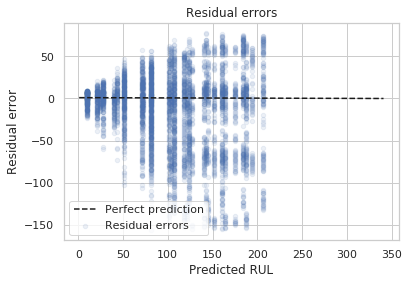

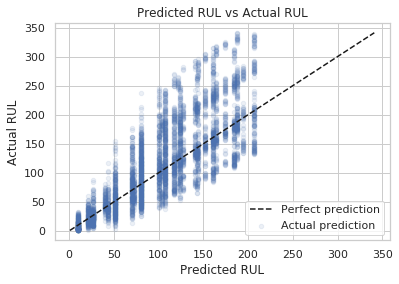

,train_rmse,train_r2,test_rmse,test_r2
DecisionTreeRegressor,36.7,0.7,49.1,0.59


In [36]:
steps = [('est', DecisionTreeRegressor(random_state=1))]

params = {
    'est__max_depth': np.arange(1, 10),
}

results = run_pipeline(steps, params, results)
results.sort_values('test_rmse')

## Linear regression

Best parameters: {}
{'train_rmse': 38.7, 'train_r2': 0.67}
{'test_rmse': 52.1, 'test_r2': 0.54}


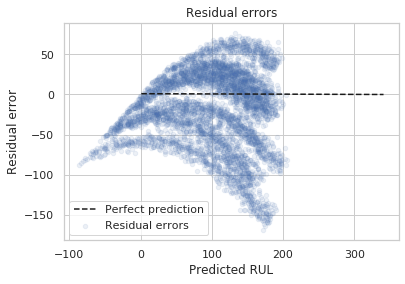

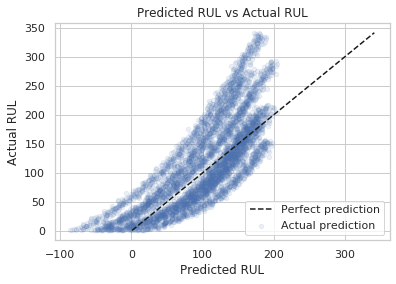

,train_rmse,train_r2,test_rmse,test_r2
DecisionTreeRegressor,36.7,0.70,49.1,0.59
LinearRegression,38.7,0.67,52.1,0.54


In [37]:
steps = [('scaler', StandardScaler()),
         ('est', LinearRegression())]

params = {
    
}

results = run_pipeline(steps, params, results)
results.sort_values('test_rmse')

## Random forest

Best parameters: {'est__n_estimators': 110}
{'train_rmse': 36.3, 'train_r2': 0.71}
{'test_rmse': 47.0, 'test_r2': 0.63}


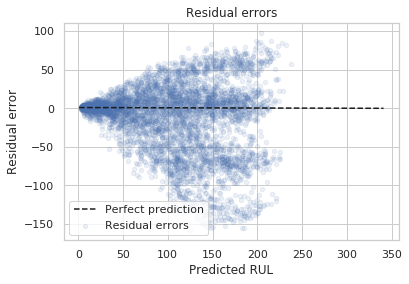

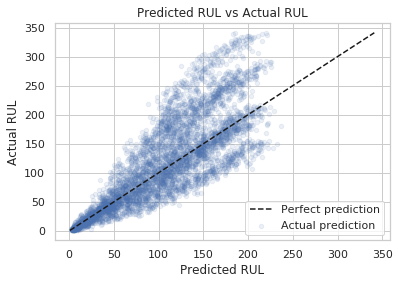

,train_rmse,train_r2,test_rmse,test_r2
RandomForestRegressor,36.3,0.71,47.0,0.63
DecisionTreeRegressor,36.7,0.70,49.1,0.59
LinearRegression,38.7,0.67,52.1,0.54


In [38]:
steps = [('est', RandomForestRegressor(n_jobs=-1))]

params = {
    'est__n_estimators': np.arange(10, 210, 50)
}

results = run_pipeline(steps, params, results, verbose=0)
results.sort_values('test_rmse')

## XGBoost

In [39]:
from xgboost import XGBRegressor

Fitting 4 folds for each of 405 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  2.1min finished


Best parameters: {'est__colsample_bytree': 0.6, 'est__gamma': 0.5, 'est__max_depth': 3, 'est__min_child_weight': 1, 'est__subsample': 1.0}
{'train_rmse': 36.6, 'train_r2': 0.7}
{'test_rmse': 47.3, 'test_r2': 0.62}


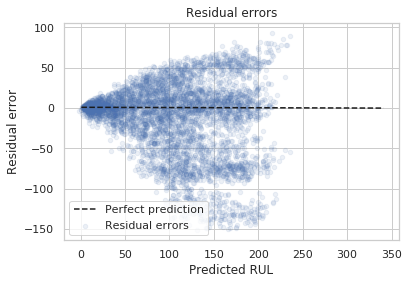

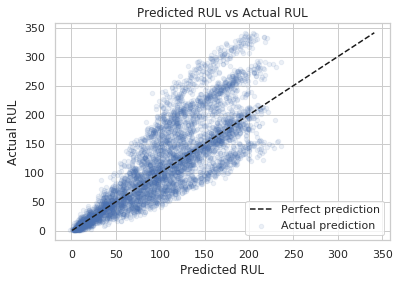

,train_rmse,train_r2,test_rmse,test_r2
RandomForestRegressor,36.3,0.71,47.0,0.63
XGBRegressor,36.6,0.70,47.3,0.62
DecisionTreeRegressor,36.7,0.70,49.1,0.59
LinearRegression,38.7,0.67,52.1,0.54


In [40]:
steps = [('scaler', StandardScaler()),
         ('est', XGBRegressor(n_jobs=-1))]

params = {
    'est__min_child_weight': [1, 5, 10],
    'est__gamma': [0.5, 1, 1.5, 2, 5],
    'est__subsample': [0.6, 0.8, 1.0],
    'est__colsample_bytree': [0.6, 0.8, 1.0],
    'est__max_depth': [3, 4, 5]
}

results = run_pipeline(steps, params, results, verbose=1)
results.sort_values('test_rmse')